# A Successful Attempt to Predict Future Asset Price Change Using Technical Indicators
(This notebook is created by [liyinnbw](https://github.com/liyinnbw/ML/tree/master/PriceChangePrediction) under the MIT license.)

Problem Definition:

* Given a time series of past N days of an asset's trading data (including price, volume, etc.) predict the average price change in next M days.

## Import 3rd Party
If not running in colab:

Install Ta-Lib on your local machine and comment OUT the following code.

In [1]:
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
!pip install Ta-Lib

--2020-02-06 03:40:56--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 216.105.38.13
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|216.105.38.13|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2020-02-06 03:40:56--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 216.105.38.13
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent, awaiting response... 302 Found
Location: https://versaweb.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2020-02-06 03:40:56--  https://versaweb.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving versaweb.dl.so

## Download Data

## Load Data

In [2]:
import pandas as pd
import numpy as np

df_o = pd.read_csv('https://raw.githubusercontent.com/liyinnbw/ML/master/PriceChangePrediction/daily_QQQ.csv')
df = df_o.sort_values(['timestamp'])
df = df.reset_index(drop=True)
df


,timestamp,open,high,low,close,volume
0,2000-02-03,188.60,193.300,184.6000,193.00,15289900
1,2000-02-04,194.00,196.500,192.4000,194.30,13320000
2,2000-02-07,194.50,197.300,192.5000,197.00,8880500
3,2000-02-08,198.80,205.800,198.8000,205.30,10999700
4,2000-02-09,204.10,204.400,197.5000,198.00,13629100
...,...,...,...,...,...,...
5027,2020-01-29,222.66,222.930,220.8300,221.81,29063128
5028,2020-01-30,220.37,222.700,219.6891,222.60,39568093
5029,2020-01-31,223.50,223.560,218.2850,219.07,52015832
5030,2020-02-03,220.14,222.885,219.9900,222.38,25468307


## Compute Tech Indicators & Close Price Change

In [3]:
import talib
df_features = pd.DataFrame()

# SMA
windows = [5, 10, 20, 50, 100, 200]
for i in windows:
    df_features['close_sma{}'.format(i)] = talib.SMA(df['close'], timeperiod=i)
df_features.iloc[:,:6] = df_features.iloc[:,:6].div(df_features.iloc[:,0], axis=0)-1


# RSI
df_features['close_rsi'] = talib.RSI(df['close'], timeperiod=14)/100

# MACD
macd, macdsignal, macdhist = talib.MACD(df['close'], fastperiod=12, slowperiod=26, signalperiod=9)
df_features['close_macd'] = macd/macdsignal-1

# OBV
df_features['obv'] = talib.OBV(df['close'], df['volume'])
df_features['obv'] = df_features['obv'].pct_change()

# Close Price Change
look_ahead_days = 5
df_features['y'] = df['close'].rolling(window=look_ahead_days).mean().shift(-look_ahead_days)/df['close']-1
# df_ma['next_day_close_fractional_change'] = df['close'].pct_change().shift(-1)
df_features = df_features.dropna()
df_features

,close_sma5,close_sma10,close_sma20,close_sma50,close_sma100,close_sma200,close_rsi,close_macd,obv,y
199,0.0,0.044038,0.070318,0.131784,0.203647,0.471895,0.453414,0.099540,-0.093029,-0.090333
200,0.0,0.039639,0.070217,0.133556,0.210090,0.474959,0.391736,0.135356,0.092080,-0.040862
201,0.0,0.022816,0.058011,0.124240,0.203711,0.462473,0.391099,0.139979,0.124150,-0.049183
202,0.0,0.011307,0.052679,0.124114,0.207286,0.461786,0.354271,0.196701,0.103687,-0.021386
203,0.0,0.011221,0.061566,0.137025,0.224291,0.476987,0.352945,0.208412,0.084456,-0.039369
...,...,...,...,...,...,...,...,...,...,...
5022,0.0,-0.007808,-0.023801,-0.058401,-0.098331,-0.130846,0.792194,0.081384,0.004151,-0.009559
5023,0.0,-0.008403,-0.024803,-0.060035,-0.100256,-0.133402,0.802439,0.073276,0.005281,-0.014506
5024,0.0,-0.007117,-0.022759,-0.058443,-0.099019,-0.132872,0.704283,0.025146,-0.007423,-0.009403
5025,0.0,-0.002553,-0.017152,-0.052486,-0.093284,-0.128024,0.533299,-0.091881,-0.008443,0.015415


## Plot Correlation Matrix

In [68]:
corr_mat = df_features.iloc[:,1:].corr()
corr_mat.style.background_gradient(cmap='coolwarm')

,close_sma10,close_sma20,close_sma50,close_sma100,close_sma200,close_rsi,close_macd,obv,y
close_sma10,1,0.822941,0.557414,0.410543,0.309053,-0.629726,0.00619856,-0.00514328,0.0431111
close_sma20,0.822941,1,0.80509,0.616838,0.470297,-0.730713,0.013922,-0.0133417,0.0124896
close_sma50,0.557414,0.80509,1,0.889325,0.717117,-0.693781,0.00329856,-0.0237175,0.0041766
close_sma100,0.410543,0.616838,0.889325,1,0.900702,-0.572567,-0.00464955,-0.0250245,-0.00511725
close_sma200,0.309053,0.470297,0.717117,0.900702,1,-0.450281,-0.00134079,-0.0155968,-0.0168845
close_rsi,-0.629726,-0.730713,-0.693781,-0.572567,-0.450281,1,-0.0131624,0.0113695,-0.0324722
close_macd,0.00619856,0.013922,0.00329856,-0.00464955,-0.00134079,-0.0131624,1,-0.000464812,-0.0120948
obv,-0.00514328,-0.0133417,-0.0237175,-0.0250245,-0.0155968,0.0113695,-0.000464812,1,0.00523616
y,0.0431111,0.0124896,0.0041766,-0.00511725,-0.0168845,-0.0324722,-0.0120948,0.00523616,1


## Prepare Input Features and Output Labels
* Input feature (x): N days history of features up till today (dimension: ?, N, 5)
* Output label (y): The next day close price change from today (dimension: ?, 1)

In [4]:
history_days = 20

features = df_features.iloc[:, 1:-1].values 
x = np.array([features[i:i+history_days] for i in range(0, len(features)-history_days+1)])
y = df_features.iloc[:,-1].values[history_days-1:].reshape(-1,1)

# print(x)
# print(y)
print(x.shape, y.shape)
print('fraction of samples with positive price change in future = {}'.format(len(np.where(y>0)[0])/len(y)))

(4809, 20, 8) (4809, 1)
fraction of samples with positive price change in future = 0.5610313994593471


## Visualize Label Distribution
The distribution is quite balanced which is good.

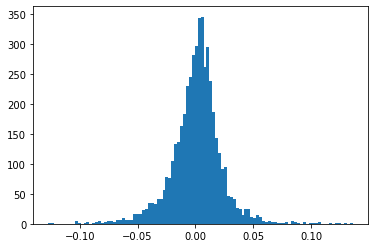

In [5]:
import matplotlib.pyplot as plt

_ = plt.hist(y, bins='auto')  # arguments are passed to np.histogram

## Prepare Training and Testing data
Because stock has bear and bull markets, we should sample randomly from the full data to get test samples. Otherwise, the test result may not be representative enough.

In [27]:
import numpy as np

totalsamples = x.shape[0]
testsamples = 300
idxs = np.arange(totalsamples)
np.random.shuffle(idxs)

x_train = x[idxs][:-testsamples]
y_train = y[idxs][:-testsamples]
x_test = x[idxs][-testsamples:]
y_test = y[idxs][-testsamples:]

print(x_train.shape, y_train.shape, len(np.where(y_train>0)[0])/len(y_train))
print(x_test.shape, y_test.shape, len(np.where(y_test>0)[0])/len(y_test))

(4509, 20, 8) (4509, 1) 0.5630960301618985
(300, 20, 8) (300, 1) 0.53


## Benchmark Training
Apply some non-neural-net models for benchmarking purpose
* K-nearest neighbours regressor
* Decision Tree Regressor
* Linear Regressor
* Ridge Regressor
* Support Vector Regressor

In [0]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor

from sklearn.model_selection import cross_val_score

x_train_benchmark = x_train.reshape(len(x_train),-1)
y_train_benchmark =y_train.reshape(-1)
x_test_benchmark = x_test.reshape(len(x_test),-1)
y_test_benchmark = y_test.reshape(-1)


models = [
    KNeighborsRegressor(n_neighbors = 5),
    DecisionTreeRegressor(),
    LinearRegression(),
    Ridge(),
    # Lasso(random_state=27),
    # SGDRegressor(loss="squared_loss"),
    # BayesianRidge(),
    # ElasticNet(random_state=27),
    SVR(),
    # GaussianProcessRegressor(random_state = 27),
    # AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=3))
]


CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, x_train_benchmark, y_train_benchmark, scoring='neg_mean_squared_error', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'negative_mse'])

## Visualize Cross Validation Results to Pick Best Benchmarking Model

[Text(0, 0, 'KNeighborsRegressor'),
 Text(0, 0, 'DecisionTreeRegressor'),
 Text(0, 0, 'LinearRegression'),
 Text(0, 0, 'Ridge'),
 Text(0, 0, 'SVR')]

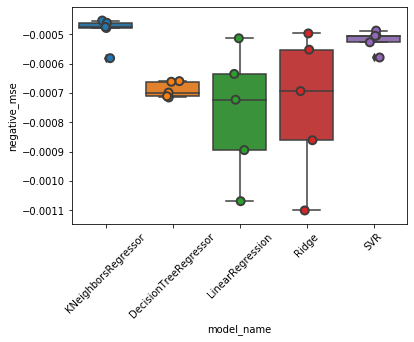

In [127]:
import seaborn as sns
chart = sns.boxplot(x='model_name', y='negative_mse', data=cv_df)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
chart = sns.stripplot(x='model_name', y='negative_mse', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)

## Test on Selected Benchmark Model

fraction of test cases with positive price change in future = 0.53
predicted price movement direction accuracy = 0.59


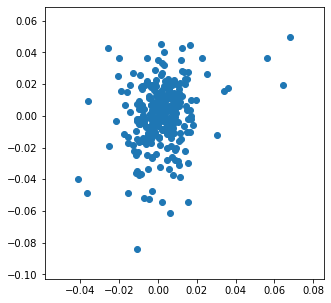

In [156]:
model_idx = 0
models[model_idx].fit(x_train_benchmark,y_train_benchmark)
y_pred_benchmark = models[model_idx].predict(x_test_benchmark)

import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.scatter(y_pred_benchmark.reshape(-1), y_test_benchmark.reshape(-1) )
# plt.plot(range(len(y_pred_benchmark)),y_pred_benchmark,color='blue')
# plt.plot(range(len(y_test_benchmark)),y_test_benchmark,color='deepskyblue')


print('fraction of test cases with positive price change in future = {}'.format(len(np.where(y_test_benchmark>0)[0])/len(y_test_benchmark)))
print('predicted price movement direction accuracy = {}'.format(len(np.where(np.multiply(y_pred_benchmark,y_test_benchmark)>0)[0])/len(y_pred_benchmark)))

## NetGenerator
This can be simple as a model definition, but wrapped inside a generator so that you can define multiple models for experimenting

In [0]:
import tensorflow as tf
from keras import optimizers

class NetGenerator():
  def __init__(self, input_shape, out_size):
    self.input_shape = input_shape
    self.out_size = out_size

  def next(self):

    modelnames =[
      'lstm',
    ]
     
    for idx, name in enumerate(modelnames):
      
      model = None
      inputs = keras.Input(shape=self.input_shape)
    #   x = keras.layers.Flatten()(inputs)
    #   x = keras.layers.Dense(128)(x)
    #   x = keras.layers.Activation('relu')(x)
    #   x = keras.layers.Dense(64)(x)
    #   x = keras.layers.Activation('relu')(x)
    #   x = keras.layers.Dense(32)(x)
    #   x = keras.layers.Activation('relu')(x)

    #   x = keras.layers.Conv1D(filters=20, kernel_size=3, strides=1,padding='same')(inputs)
    #   x = keras.layers.BatchNormalization()(x)
    #   x = keras.layers.Activation('relu')(x)
      
# #       if idx == 0:
# #         x = keras.layers.Dense(self.out_size)(x)
# # #         x= keras.layers.Dropout(0.5)(x)
# #       elif idx == 1:
      x = keras.layers.LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)(inputs)
      x = keras.layers.BatchNormalization()(x)
      x = keras.layers.LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=False)(x)
      x = keras.layers.BatchNormalization()(x)
    #   x = keras.layers.Flatten()(x)
      
      x = keras.layers.Dense(self.out_size)(x)
      x = keras.layers.Activation('tanh')(x)
      model = keras.Model(inputs=inputs, outputs=x)
      model.compile(
          loss='mean_squared_error',
          optimizer=optimizers.Adam(lr=0.001)
      )

      yield (name, model)


## Training On Neural Net
Uncomment the following for training stats visualization when using colab.

In [8]:
# !pip install tensorboardcolab
# from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback

# tbc=TensorBoardColab(port=6007, graph_path='.', startup_waiting_time=8)

Wait for 8 seconds...
TensorBoard link:
http://473efd9e.ngrok.io


In [16]:
import keras
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras import backend as K 
import tensorflow as tf

print (keras.__version__)
print (tf.__version__)

net_gen = NetGenerator(
    input_shape=x_train[0].shape, 
    out_size=y_train[0].shape[0], 
)

# very important or error
K.clear_session()
net_generator = net_gen.next()
modelconfig=next(net_generator,None)
  
while modelconfig!=None:

    modelname,model = modelconfig

    print(modelname)
    model.summary()

    cb_tensorboard = TensorBoard(
        log_dir='./log/'+modelname,
        histogram_freq=100,  
        write_graph=True, 
        write_images=False,
        write_grads=False,
#         update_freq ='epoch'
    )

    cb_checkpoint = ModelCheckpoint(
        './log/'+modelname+'_weights.h5', 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=True, 
        mode='auto', 
        period=1
    )

    model.fit(
        x=x_train, 
        y=y_train, 
        batch_size=265, 
        epochs=5000, 
        verbose=1, 
        callbacks=[cb_tensorboard, cb_checkpoint], 
        validation_split=0.1, 
        shuffle=True, 
        initial_epoch=0, 
        steps_per_epoch=None, 
        validation_steps=None, 
    )
    
    # very important or error
    K.clear_session()
    modelconfig=next(net_generator,None)

print('All done')

2.2.5
1.15.0
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
lstm
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 20, 8)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 20, 128)           70144     
_________________________________________________________________
batch_normalization_1 (Batch (None, 20, 128)           512       
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129

## Testing
* If the prediction is correct, the dots should form 45 degree diagonal line(y_pred = y_test).
* If the prediction sign is correct, the dots should be in first or third quadrant.

fraction of test cases with positive price change in future = 0.53
predicted price movement direction accuracy = 0.8166666666666667


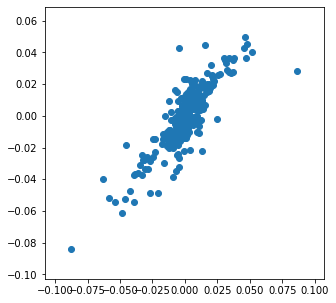

In [157]:
import matplotlib.pyplot as plt

K.clear_session()
net_generator = net_gen.next()
modelconfig=next(net_generator,None)
modelname,model = modelconfig
model.load_weights('log/'+modelname+'_weights.h5')

x_eval = x_test
y_eval = y_test


y_pred = model.predict(x_eval)

plt.figure(figsize=(5,5))
plt.scatter(y_pred.reshape(-1), y_eval.reshape(-1) )
# plt.plot(range(y_pred.shape[0]),y_pred[:,0],color='blue')
# plt.plot(range(y_eval.shape[0]),y_eval[:,0],color='deepskyblue')

print('fraction of test cases with positive price change in future = {}'.format(len(np.where(y_eval>0)[0])/len(y_eval)))
print('predicted price movement direction accuracy = {}'.format(len(np.where(np.multiply(y_eval,y_pred)>0)[0])/len(y_eval)))

## Tracing Training Asset With Trained Model
* This is a rather trivial task, as we apply our trained model on the training asset. Nevertheless, this helps to confirm if our training result is good. 
* Note that when tracing the asset price, we will not accumulate predicted price changes on just the starting price, but rather, we will apply the predicted price change on the last observed day's closing price to get the next day predicted price. I think this is a logical way of using the model in practice.
* Also note that we are loosely using the predicted change as next day change. But when we trained our model, we actually set y to be the average price change over the next M days. This is ok because using avaerage price change is actually a more stable prediction of the next day price.

You will see that the predicted price quite closely follows the actual price which is expected.

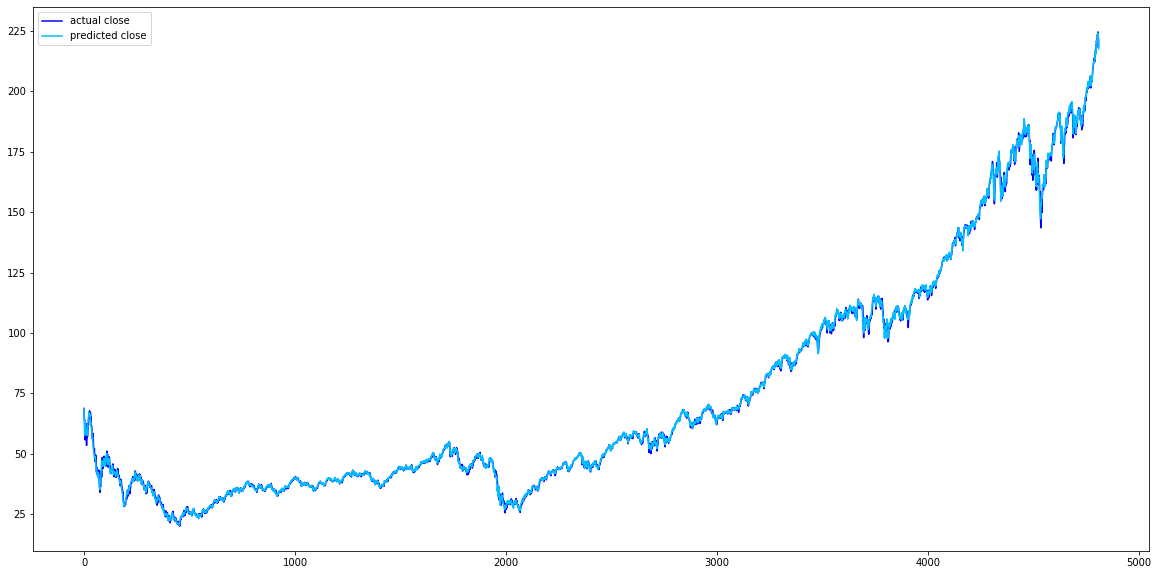

In [208]:
import pandas as pd
import numpy as np

df2_o = pd.read_csv('https://raw.githubusercontent.com/liyinnbw/ML/master/PriceChangePrediction/daily_QQQ.csv')
df2 = df2_o.sort_values(['timestamp'])
df2 = df2.reset_index(drop=True)

import talib
df_test = pd.DataFrame()

# SMA
windows = [5, 10, 20, 50, 100, 200]
for i in windows:
    df_test['close_sma{}'.format(i)] = talib.SMA(df2['close'], timeperiod=i)
df_test.iloc[:,:6] = df_test.iloc[:,:6].div(df_test.iloc[:,0], axis=0)-1


# RSI
df_test['close_rsi'] = talib.RSI(df2['close'], timeperiod=14)/100

# MACD
macd, macdsignal, macdhist = talib.MACD(df2['close'], fastperiod=12, slowperiod=26, signalperiod=9)
df_test['close_macd'] = macd/macdsignal-1

# OBV
df_test['obv'] = talib.OBV(df2['close'], df2['volume'])
df_test['obv'] = df_test['obv'].pct_change()

# daily close prices
df_test['close'] = df2['close']

# average close prices in future
look_ahead_days = 5
df_test['average_close_in_next_{}_days'.format(look_ahead_days)] = df_test['close'].rolling(window=look_ahead_days).mean().shift(-look_ahead_days)


df_test = df_test.dropna()

test_features = df_test[['close_sma10','close_sma20','close_sma50','close_sma100','close_sma200','close_rsi','close_macd','obv']].values
test_input = np.array([test_features[i:i+history_days] for i in range(0, len(test_features)-history_days+1)])
actual_today_close = df_test['close'][history_days-1:].values

predicted_change = model.predict(test_input).reshape(-1)
predicted_tmr_close = np.array([close*(1+change) for close, change in zip(actual_today_close, predicted_change)])
predicted_tmr_close = np.roll(predicted_tmr_close,1) # shift right by 1 day because it is next day close
predicted_tmr_close[0] = actual_today_close[0] # because we don't predict for today

import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(range(actual_today_close.shape[0]),actual_today_close,color='blue',label='actual close')
plt.plot(range(predicted_tmr_close.shape[0]),predicted_tmr_close,color='deepskyblue', label='predicted close')
plt.legend()

## Trading Training Asset Using Trained Model
If we start with 100 dollar cash, employ the following simple strategy:
* Sell all asset if predicted average price in future is negative if you own the asset.
* Buy all asset if predicted average price in future is positive if you do not own the asset.
* Assume no trading cost.
* Assume you always trade at market close price.

You will see that the profit is huge.

start portfolio value = 100
end portflolio value = 62625736.812591985


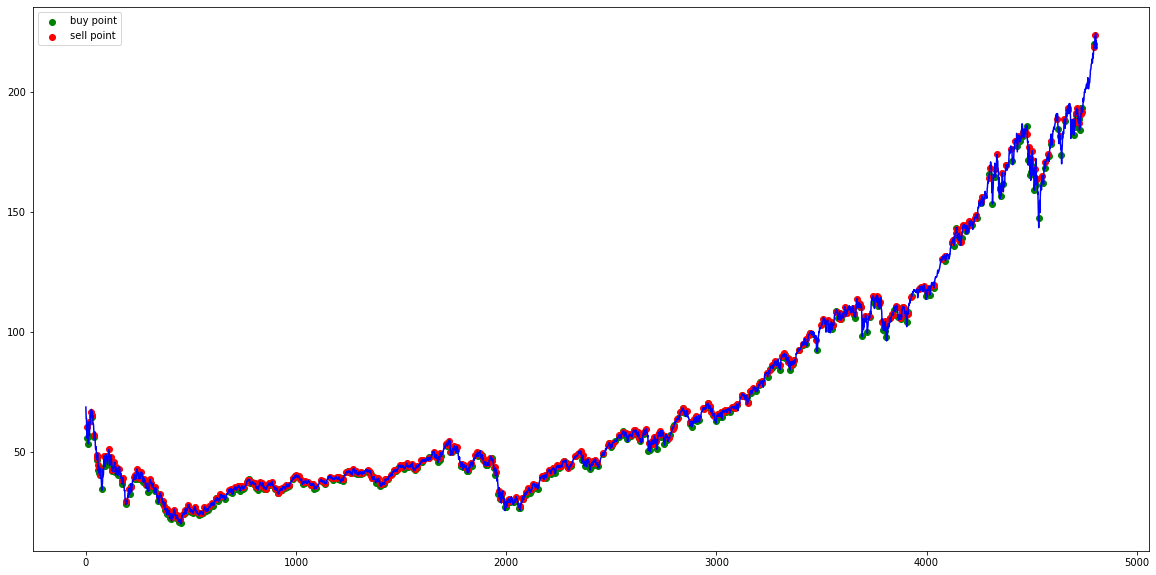

In [207]:
cash = 100
assets = 0
action_change = 0.00
print('start portfolio value = {}'.format(cash))

buy_x = []
buy_y = []
sell_x = []
sell_y = []
idx = 0
for close, change in zip(actual_today_close, predicted_change):
    if change>action_change and assets == 0:
        assets = cash/close
        cash = 0
        buy_x.append(idx)
        buy_y.append(close)
    elif change<-action_change and assets>0:
        cash = assets*close
        assets = 0
        sell_x.append(idx)
        sell_y.append(close)
    idx += 1


print('end portflolio value = {}'.format(cash+assets*actual_today_close[-1]))

import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(range(actual_today_close.shape[0]),actual_today_close,color='blue')
plt.scatter(buy_x, buy_y, c='green', label='buy point')
plt.scatter(sell_x, sell_y, c='red', label='sell point')
plt.legend()

## Tracing Unseen Asset With Trained Model
This task is more interesting as we test how well our model generalizes to predict an unseen asset. The result is expected to be worse than the training asset, but not quite that bad.


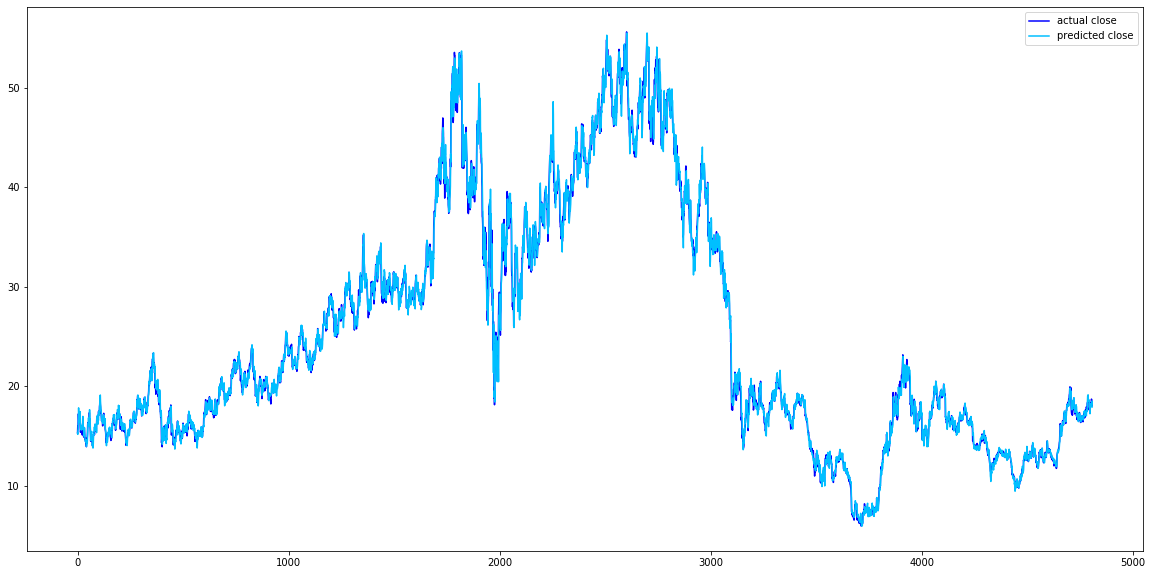

In [217]:
import pandas as pd
import numpy as np

df2_o = pd.read_csv('https://raw.githubusercontent.com/liyinnbw/ML/master/PriceChangePrediction/daily_GOLD.csv')
df2 = df2_o.sort_values(['timestamp'])
df2 = df2.reset_index(drop=True)

import talib
df_test = pd.DataFrame()

# SMA
windows = [5, 10, 20, 50, 100, 200]
for i in windows:
    df_test['close_sma{}'.format(i)] = talib.SMA(df2['close'], timeperiod=i)
df_test.iloc[:,:6] = df_test.iloc[:,:6].div(df_test.iloc[:,0], axis=0)-1


# RSI
df_test['close_rsi'] = talib.RSI(df2['close'], timeperiod=14)/100

# MACD
macd, macdsignal, macdhist = talib.MACD(df2['close'], fastperiod=12, slowperiod=26, signalperiod=9)
df_test['close_macd'] = macd/macdsignal-1

# OBV
df_test['obv'] = talib.OBV(df2['close'], df2['volume'])
df_test['obv'] = df_test['obv'].pct_change()

# daily close prices
df_test['close'] = df2['close']

# average close prices in future
look_ahead_days = 5
df_test['average_close_in_next_{}_days'.format(look_ahead_days)] = df_test['close'].rolling(window=look_ahead_days).mean().shift(-look_ahead_days)


df_test = df_test.dropna()

test_features = df_test[['close_sma10','close_sma20','close_sma50','close_sma100','close_sma200','close_rsi','close_macd','obv']].values
test_input = np.array([test_features[i:i+history_days] for i in range(0, len(test_features)-history_days+1)])
actual_today_close = df_test['close'][history_days-1:].values

predicted_change = model.predict(test_input).reshape(-1)
predicted_tmr_close = np.array([close*(1+change) for close, change in zip(actual_today_close, predicted_change)])
predicted_tmr_close = np.roll(predicted_tmr_close,1) # shift right by 1 day because it is next day close
predicted_tmr_close[0] = actual_today_close[0] # because we don't predict for today

import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(range(actual_today_close.shape[0]),actual_today_close,color='blue',label='actual close')
plt.plot(range(predicted_tmr_close.shape[0]),predicted_tmr_close,color='deepskyblue', label='predicted close')
plt.legend()


## Trading Unseen Asset Using Trained Model
Same strategy as before. This time, the profit is expected to be much less.

start portfolio value = 100
end portflolio value = 273.10239165102894


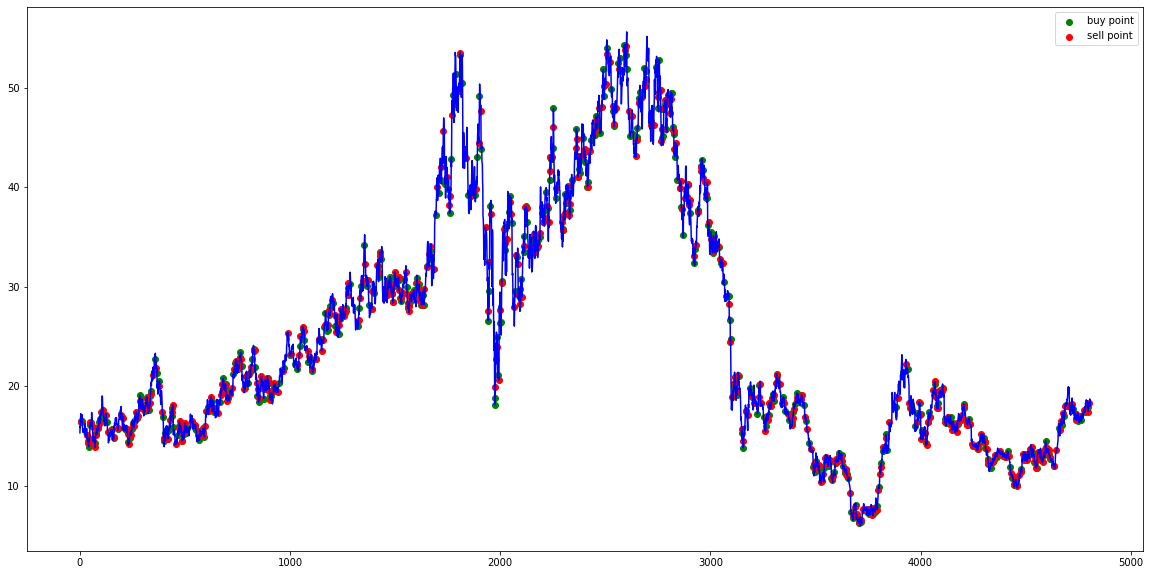

In [210]:
cash = 100
assets = 0
action_change = 0.00
print('start portfolio value = {}'.format(cash))

buy_x = []
buy_y = []
sell_x = []
sell_y = []
idx = 0
for close, change in zip(actual_today_close, predicted_change):
    if change>action_change and assets == 0:
        assets = cash/close
        cash = 0
        buy_x.append(idx)
        buy_y.append(close)
    elif change<-action_change and assets>0:
        cash = assets*close
        assets = 0
        sell_x.append(idx)
        sell_y.append(close)
    idx += 1


print('end portflolio value = {}'.format(cash+assets*actual_today_close[-1]))

import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(range(actual_today_close.shape[0]),actual_today_close,color='blue')
plt.scatter(buy_x, buy_y, c='green', label='buy point')
plt.scatter(sell_x, sell_y, c='red', label='sell point')
plt.legend()

## Tracing A Young and Volatile Asset Using Trained Model
When testing on a new and volatile asset, the model does not perform as good as before.

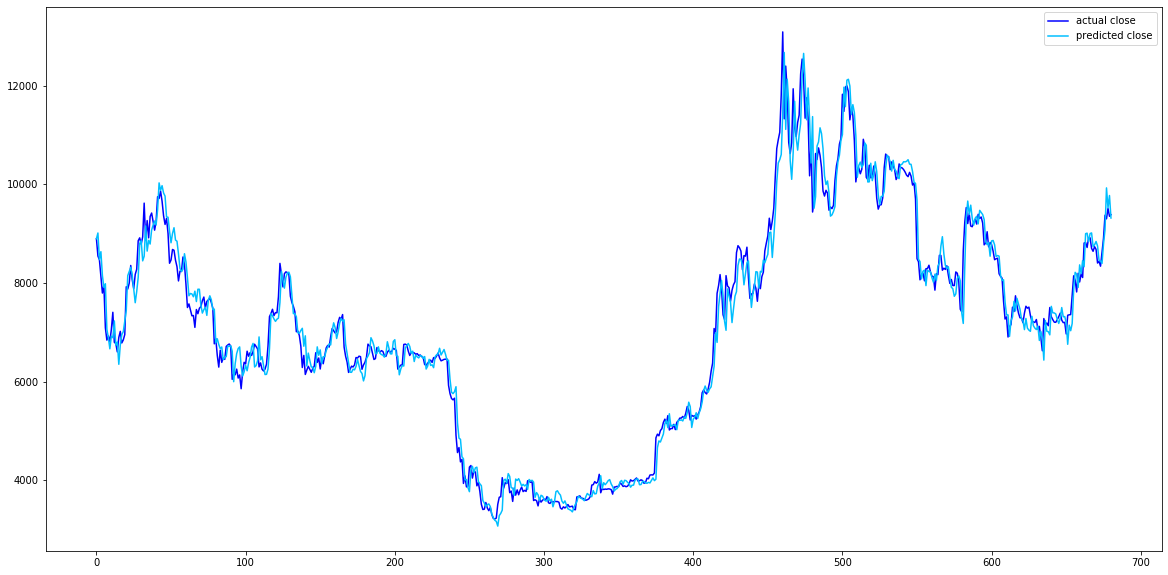

In [218]:
import pandas as pd
import numpy as np

df2_o = pd.read_csv('https://raw.githubusercontent.com/liyinnbw/ML/master/PriceChangePrediction/daily_BTC_USD.csv')
df2 = df2_o.sort_values(['timestamp'])
df2 = df2.reset_index(drop=True)
df2['close'] = df2['close (USD)']

import talib
df_test = pd.DataFrame()

# SMA
windows = [5, 10, 20, 50, 100, 200]
for i in windows:
    df_test['close_sma{}'.format(i)] = talib.SMA(df2['close'], timeperiod=i)
df_test.iloc[:,:6] = df_test.iloc[:,:6].div(df_test.iloc[:,0], axis=0)-1


# RSI
df_test['close_rsi'] = talib.RSI(df2['close'], timeperiod=14)/100

# MACD
macd, macdsignal, macdhist = talib.MACD(df2['close'], fastperiod=12, slowperiod=26, signalperiod=9)
df_test['close_macd'] = macd/macdsignal-1

# OBV
df_test['obv'] = talib.OBV(df2['close'], df2['volume'])
df_test['obv'] = df_test['obv'].pct_change()

# daily close prices
df_test['close'] = df2['close']

# average close prices in future
look_ahead_days = 5
df_test['average_close_in_next_{}_days'.format(look_ahead_days)] = df_test['close'].rolling(window=look_ahead_days).mean().shift(-look_ahead_days)


df_test = df_test.dropna()

test_features = df_test[['close_sma10','close_sma20','close_sma50','close_sma100','close_sma200','close_rsi','close_macd','obv']].values
test_input = np.array([test_features[i:i+history_days] for i in range(0, len(test_features)-history_days+1)])
actual_today_close = df_test['close'][history_days-1:].values

predicted_change = model.predict(test_input).reshape(-1)
predicted_tmr_close = np.array([close*(1+change) for close, change in zip(actual_today_close, predicted_change)])
predicted_tmr_close = np.roll(predicted_tmr_close,1) # shift right by 1 day because it is next day close
predicted_tmr_close[0] = actual_today_close[0] # because we don't predict for today

import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(range(actual_today_close.shape[0]),actual_today_close,color='blue',label='actual close')
plt.plot(range(predicted_tmr_close.shape[0]),predicted_tmr_close,color='deepskyblue', label='predicted close')
plt.legend()

## Trading A Young and Volatile Asset Using Trained Model
This time, the model is making a loss.

start portfolio value = 100
end portflolio value = 58.640566193172944


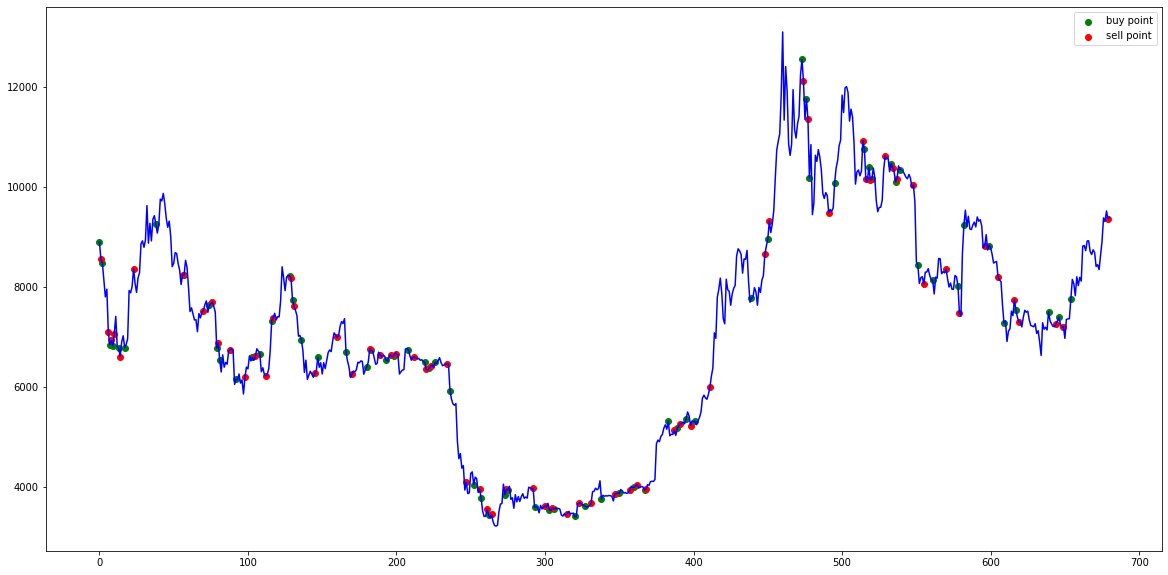

In [216]:
cash = 100
assets = 0
action_change = 0.00
print('start portfolio value = {}'.format(cash))

buy_x = []
buy_y = []
sell_x = []
sell_y = []
idx = 0
for close, change in zip(actual_today_close, predicted_change):
    if change>action_change and assets == 0:
        assets = cash/close
        cash = 0
        buy_x.append(idx)
        buy_y.append(close)
    elif change<-action_change and assets>0:
        cash = assets*close
        assets = 0
        sell_x.append(idx)
        sell_y.append(close)
    idx += 1


print('end portflolio value = {}'.format(cash+assets*actual_today_close[-1]))

import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(range(actual_today_close.shape[0]),actual_today_close,color='blue')
plt.scatter(buy_x, buy_y, c='green', label='buy point')
plt.scatter(sell_x, sell_y, c='red', label='sell point')
plt.legend()

## Conclusion
* LSTM is able to predict price change (as shown from above graph).
* LSTM performs significantly better than benchmark models.
* The reason why LSTM is able to learn pattern from technical indicator features but not directly from raw price and volume history could be:
    * Preprocessing raw price and volume to technical indicators reduced the search space.
    * Some technical indicators such as SMA200 summarized a very long history. But when training on raw price and volume history, we did not use that long history due to concerns over the input dimension (because we have limited samples and there is this "curse of dimensionality" problem).
* The model does not generalize well to other assets. However, we may improve it by provide multiple training asset, each with a different characteristic.